# Background

- Want to analyze all of the survey data
- Make sure to do a slow scan save (probably just SmarAct, as long as the data output looks fine) each time we make a measurement
    - Should I set the "scan" time to be very high so we don't accidentally save something when we don't mean to?
- Get data from the survey group.
    - If it is in a strange format, it may be worthwhile to first process this data in another notebook.

1. Calibration magnet pole cap surface mapping.
    - Look at planarity
    - Extract vector direction of the field.
2. SmarAct stage
    - Determine motor angles to have kinematic mounting plate with normal along B vector.
    - Check repeatability of placing SmarAct in the magnet.
    - Check repeatability of moving the SmarAct to a few different locations.
    - Verify SmarAct encoders for both motors readout corresponds to the actual angle measured.
    - **Create a mapping between SmarAct motor angles and $\theta, \phi$ of field vector w.r.t. some reproducible fiducials on the kinematic plate.**
        - This is the crucial piece that I require to achieve calibration requirements on field vector orientation.

# Imports

In [545]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [546]:
import os
import numpy as np
import pandas as pd
import lmfit as lm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

from plotting import config_plots, get_label
config_plots()

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

from load_slow import load_data

In [547]:
raw_ddir = '/home/ckampa/Dropbox/LogFiles/survey_12-06-22/'
proc_ddir = 'data/'
plot_dir = 'plots/'

# Quick Calculations

- Plate has points separatated by O(5-10) cm
- Let's assume absolute best lever arm on this plate is 5 cm.
- What does the angular accuracy requirement (0.1 mrad) say about how well we need to track a point in x,y,z?
- z between poles
- x "to the right"
- y "up"

In [9]:
req_angle = 1e-4
req_angle_deg = np.degrees(req_angle)
req_angle, req_angle_deg

(0.0001, 0.005729577951308232)

In [10]:
lever_arm_best = 0.05 # m

In [15]:
## angle 0

In [16]:
# delta z
lever_arm_best * np.sin(req_angle)

4.9999999916666675e-06

In [18]:
# delta x
lever_arm_best * np.cos(req_angle) - lever_arm_best

-2.4999999986841104e-10

In [20]:
np.cos(req_angle)

0.999999995

In [24]:
def inch_to_m(inch):
    return 0.0254 * inch

def mm_to_inch(inch):
    return inch/25.4

In [25]:
inch_to_m(0.006)

0.0001524

In [26]:
inch_to_m(0.006)

0.0001524

In [28]:
mm_to_inch(56.495) / 2

1.1121062992125985

In [ ]:
###########

In [549]:
data = {'a': [[0, 1], [], [2], [3,4,5], []], 'b': [0, 1, 2, 3, 4]}

In [550]:
df_test = pd.DataFrame(data)

In [551]:
df_test

,a,b
0,"[0, 1]",0
1,[],1
2,[2],2
3,"[3, 4, 5]",3
4,[],4


# Day 0 Results (pole tips)

# Day 1 Results (12-06-22)

PRELIMINARY ANALYSIS ONLY!
- X, Y, Z all in units of inches

In [474]:
# survey_ddir = '/home/ckampa/Dropbox/LogFiles/06Dec22_Survey_Data/' # Day 1
#survey_ddir = '/home/ckampa/Dropbox/LogFiles/08Dec22_Survey_Data/' # Day 2/3
survey_ddir = '/home/ckampa/Dropbox/LogFiles/Dec22_Survey_Data/' # combined

In [475]:
files = os.listdir(survey_ddir)

In [476]:
files

['Black Plate Repeatability - 19th Installation.txt',
 'PtOut.txt',
 'Black Plate Horizontal Rotation 0 Degrees Check.txt',
 'Black Plate Vertical Rotation 180 Degrees Check.txt',
 'Black Plate Vertical Rotation 270 Degrees.txt',
 'Black Plate Horizontal Rotation -3 Degrees.txt',
 'Black Plate Repeatability - 21st Installation.txt',
 'Black Plate Repeatability - 25th Installation Home.txt',
 'Black Plate Repeatability - 29th Installation Home  Check.txt',
 'Black Plate Repeatability - 14th Installation.txt',
 'Black Plate Vertical Rotation 15 Degrees.txt',
 'Black Plate Repeatability - 25th Installation Home Check 2.txt',
 'Black Plate Repeatability - 26th Installation Vertical 135 Degrees.txt',
 'Black Plate Repeatability - 25th Installation Check Rotated 360.txt',
 'Black Plate Vertical Rotation 180 Degrees.txt',
 'Horizontal  -5 Degrees Vertical 90 Degrees C.txt',
 'Black Plate Horizontal Rotation -8 Degrees.txt',
 'Black Plate Horizontal Rotation 6 Degrees.txt',
 'Black Plate Verti

In [477]:
def load_survey(filename):
    df = pd.read_csv(filename, skiprows=5, names=['Point', 'X', 'Y', 'Z'])
    for i in ['X', 'Y', 'Z']:
        df.loc[:, f'{i}_mm'] = inch_to_m(df.loc[:, i]) * 1e3
    return df

def make_survey_dict(ddir, files):
    survey_dict = dict()
    for f in files:
        f_short = f.replace('.txt', '').replace('Black Plate ', '')
        survey_dict[f_short] = load_survey(ddir+f)
    return survey_dict

# def plot_survey(survey_dict, key, fig=None, ax=None):

In [478]:
def calc_centroid(df):
    return df[['X', 'Y', 'Z']].mean()

# copied / altered from 12-18-2020_Hall_Probe_Card_CMM_Sample_Data_Analysis
def plane_fit_SVD(df):
    # collect positional points from dataframe
    points = df[['X','Y','Z']].values.T
    # subtract centroid
    centroid = (np.sum(points,axis=1) / len(df))
    points_c = points - centroid[:,None]
    # calculate svd
    u, _, _ = np.linalg.svd(points_c)
    # normal vector is left singular vector with least singular value
    norm_v = u[:,2]
    return norm_v, centroid

In [479]:
survey_dict = make_survey_dict(survey_ddir, files)

In [480]:
calc_centroid(survey_dict['Horizontal Rotation -10 Degrees'])
# calc_centroid(survey_dict['Horizontal Rotation -9 Degrees C'])

X    0.151053
Y    0.024860
Z   -0.510306
dtype: float64

In [481]:
plane_fit_SVD(survey_dict['Horizontal Rotation -10 Degrees'])
# plane_fit_SVD(survey_dict['Horizontal Rotation -9 Degrees C'])

(array([ 0.99144366, -0.1296743 , -0.01496817]),
 array([ 0.151053 ,  0.02486  , -0.5103056]))

In [482]:
plane_fit_SVD(survey_dict['Horizontal Rotation -9 Degrees C'])[0][0], np.linalg.norm(plane_fit_SVD(survey_dict['Horizontal Rotation -9 Degrees C'])[0][1:])

(0.9937837647862549, 0.11132757451439527)

In [483]:
np.arctan2(plane_fit_SVD(survey_dict['Horizontal Rotation -9 Degrees C'])[0][0], np.linalg.norm(plane_fit_SVD(survey_dict['Horizontal Rotation -9 Degrees C'])[0][1:]))

1.4592374977020783

In [484]:
np.degrees(np.arctan2(plane_fit_SVD(survey_dict['Horizontal Rotation -9 Degrees C'])[0][0], np.linalg.norm(plane_fit_SVD(survey_dict['Horizontal Rotation -9 Degrees C'])[0][1:])))

83.60814992556026

In [485]:
np.degrees(np.arctan2(plane_fit_SVD(survey_dict['Repeatability - 29th Installation Home  Check 3'])[0][0], np.linalg.norm(plane_fit_SVD(survey_dict['Repeatability - 29th Installation Home  Check 3'])[0][1:])))

88.97348906060395

In [486]:
Black Plate Repeatability - 29th Installation Home  Check 3

SyntaxError: invalid syntax (3962010979.py, line 1)

In [487]:
survey_analysis_dict = {}

for k, df in survey_dict.items():
    norm_v, centroid = plane_fit_SVD(df)
    survey_analysis_dict[k] = {'df': df, 'normal_vector': norm_v, 'centroid': centroid}

In [488]:
survey_analysis_dict

{'Repeatability - 19th Installation': {'df':              Point         X         Y         Z      X_mm       Y_mm  \
  0  Kinematic-0.5_A  0.115849  1.201442 -1.960842  2.942565  30.516627   
  1  Kinematic-0.5_B  0.131274 -0.557661 -2.158896  3.334360 -14.164589   
  2  Kinematic-0.5_C  0.158948 -1.325782 -0.438541  4.037279 -33.674863   
  3  Kinematic-0.5_D  0.181044 -0.291719  2.006651  4.598518  -7.409663   
  4  Kinematic-0.5_E  0.142107  1.213242  0.002348  3.609518  30.816347   
  
          Z_mm  
  0 -49.805387  
  1 -54.835958  
  2 -11.138941  
  3  50.968935  
  4   0.059639  ,
  'normal_vector': array([ 0.99987575,  0.00928198, -0.01274074]),
  'centroid': array([ 0.1458444,  0.0479044, -0.509856 ])},
 'PtOut': {'df':                Point         X         Y         Z      X_mm       Y_mm  \
  0    Kinematic-0.5_A  0.117437  1.199211 -1.960687  2.982900  30.459959   
  1    Kinematic-0.5_B  0.134125 -0.559848 -2.159250  3.406775 -14.220139   
  2    Kinematic-0.5_C  0.16

In [489]:
for k, val in survey_analysis_dict.items():
    if "Repeatability" in k:
        print(f'{k}:\ncentroid={val["centroid"]}'+f'\n normal_vector={val["normal_vector"]}')

Repeatability - 19th Installation:
centroid=[ 0.1458444  0.0479044 -0.509856 ]
 normal_vector=[ 0.99987575  0.00928198 -0.01274074]
Repeatability - 21st Installation:
centroid=[ 0.1509254  0.0385354 -0.5100728]
 normal_vector=[-0.99990558 -0.002132    0.01357504]
Repeatability - 25th Installation Home:
centroid=[ 0.1528716  0.0374066 -0.5102846]
 normal_vector=[-0.99990212 -0.0012008   0.01393922]
Repeatability - 29th Installation Home  Check:
centroid=[ 0.1523774  0.029807  -0.509503 ]
 normal_vector=[ 0.99983876  0.01153687 -0.01376078]
Repeatability - 14th Installation:
centroid=[ 0.1590448  0.0361168 -0.5104444]
 normal_vector=[ 0.99985272  0.00876902 -0.01475272]
Repeatability - 25th Installation Home Check 2:
centroid=[ 0.1457988  0.036464  -0.5092336]
 normal_vector=[-9.99917851e-01  4.87040564e-06  1.28176422e-02]
Repeatability - 26th Installation Vertical 135 Degrees:
centroid=[0.15784267 0.35233333 0.322544  ]
 normal_vector=[-0.99991196 -0.00407009  0.01262925]
Repeatability

In [490]:
mean_centroid = [[], [], []]
mean_vector = [[], [], []]
for k, val in survey_analysis_dict.items():
    if "Repeatability" in k:
#     if ("Repeatability" in k) and (not "12th" in k):
#     if ("Repeatability" in k):
#         if int(k.replace('th', '-').replace('st', '-').replace('rd', '-').replace('nd','-').split('-')[1]) >= 27:
            c = val['centroid']
            mean_centroid[0].append(c[0])
            mean_centroid[1].append(c[1])
            mean_centroid[2].append(c[2])
            v = val['normal_vector']
            mean_vector[0].append(v[0])
            mean_vector[1].append(v[1])
            mean_vector[2].append(v[2])
mean_centroid = np.mean(mean_centroid, axis=1)
mean_vector = np.mean(mean_vector, axis=1)
for k, val in survey_analysis_dict.items():
#     if "Repeatability" in k:
#     if ("Repeatability" in k) and (not "12th" in k):
        angle_rad = np.arccos(np.dot(val["normal_vector"], mean_vector) / ((np.linalg.norm(val["normal_vector"]))*(np.linalg.norm(mean_vector))))
        angle = np.degrees(angle_rad)
        print(f'{k}:\ndelta_centroid={val["centroid"]-mean_centroid}'+f'\n delta_normal_vector_angle={angle} [deg] = {angle_rad} [rad]')

Repeatability - 19th Installation:
delta_centroid=[-6.59014023e-03 -4.99080460e-05 -2.86474759e-02]
 delta_normal_vector_angle=0.22914576747772739 [deg] = 0.003999348109495685 [rad]
PtOut:
delta_centroid=[-0.00178816  0.03958344  0.08266619]
 delta_normal_vector_angle=178.29246118072584 [deg] = 3.111790479087843 [rad]
Horizontal Rotation 0 Degrees Check:
delta_centroid=[-0.00239254 -0.65049031 -1.66295348]
 delta_normal_vector_angle=90.80363639036774 [deg] = 1.5848224277956562 [rad]
Vertical Rotation 180 Degrees Check:
delta_centroid=[-0.00523204 -0.28925781  0.07826802]
 delta_normal_vector_angle=84.07737182641247 [deg] = 1.467426964794416 [rad]
Vertical Rotation 270 Degrees:
delta_centroid=[-0.00262034 -0.31921071  0.29206292]
 delta_normal_vector_angle=0.7621112945752214 [deg] = 0.013301351356974012 [rad]
Horizontal Rotation -3 Degrees:
delta_centroid=[ 0.00510886 -0.01388611 -0.02913448]
 delta_normal_vector_angle=1.197357333871153 [deg] = 0.02089782779895264 [rad]
Repeatability - 

In [528]:
# scatter plot
xs = []
ys = []
zs = []
cs = []

for i, obj in enumerate(sorted(survey_analysis_dict.items())):
    k, val = obj
    #if True:
    #if ("Repeatability" in k) and (not "Vertical" in k):
    # vertical rotation definitely moves the centroid...check again after determining transformation from centroid to Hall probe location.
#     if not "Vertical" in k:
    # INVESTIGATE THIS CASE (outlier)
    if (not "Vertical" in k) and (not "0 Degrees Check" in k) and (not "PtOut" in k):
        print(f'{i}...{k}:\ncentroid={val["centroid"]}'+f'\n normal_vector={val["normal_vector"]}')
        x_, y_, z_ = val["centroid"]
        xs.append(x_)
        ys.append(y_)
        zs.append(z_)
        cs.append(i)
xs = np.array(xs)
ys = np.array(ys)
zs = np.array(zs)

10...Horizontal Rotation -0 Degrees B:
centroid=[ 0.1526612  0.0372216 -0.51027  ]
 normal_vector=[-0.99990171 -0.0011964   0.01396895]
11...Horizontal Rotation -10 Degrees:
centroid=[ 0.151053   0.02486   -0.5103056]
 normal_vector=[ 0.99144366 -0.1296743  -0.01496817]
12...Horizontal Rotation -10 Degrees B:
centroid=[ 0.1452732  0.027208  -0.510169 ]
 normal_vector=[ 0.99032462 -0.13804045 -0.01421198]
13...Horizontal Rotation -3 Degrees:
centroid=[ 0.1575434  0.0340682 -0.510343 ]
 normal_vector=[ 0.99986148 -0.00781789 -0.01469346]
14...Horizontal Rotation -4 Degrees:
centroid=[ 0.1567362  0.0326308 -0.5103626]
 normal_vector=[ 0.99957066 -0.02530824 -0.01476419]
15...Horizontal Rotation -4 Degrees B:
centroid=[ 0.1510998  0.0346658 -0.5102252]
 normal_vector=[ 0.99933261 -0.03372604 -0.0140319 ]
16...Horizontal Rotation -4 Degrees C:
centroid=[ 0.1505496  0.027014  -0.5094334]
 normal_vector=[ 0.99963067 -0.02337393 -0.01386301]
17...Horizontal Rotation -5 Degrees:
centroid=[ 0.15

In [529]:
i

89

In [530]:
df_cent = pd.DataFrame({'X': xs, 'Y': ys, 'Z': zs, 'index': cs})

In [531]:
df_cent

,X,Y,Z,index
0,0.152661,0.037222,-0.510270,10
1,0.151053,0.024860,-0.510306,11
2,0.145273,0.027208,-0.510169,12
3,0.157543,0.034068,-0.510343,13
4,0.156736,0.032631,-0.510363,14
5,0.151100,0.034666,-0.510225,15
6,0.150550,0.027014,-0.509433,16
7,0.155848,0.031250,-0.510350,17
8,0.154940,0.029959,-0.510344,18
9,0.149229,0.032097,-0.510221,19


In [532]:
fig = px.scatter_3d(df_cent, x='X', y='Y', z='Z', color='index')
fig.add_trace(go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', marker=dict(color='Red', size=10, symbol='cross')))
# xmi = -1.; xma = 1.; ymi = -1.; yma = 1.; zmi = -1.; zma = 1.
xmi = -1.5; xma = 1.5; ymi = -5.; yma = 5.; zmi = -5.; zma = 5.
fig.add_trace(go.Scatter3d(x=[xmi, xmi, xmi, xmi, xma, xma, xma, xma], y=[ymi, ymi, yma, yma, ymi, ymi, yma, yma], z=[zmi, zma, zmi, zma, zmi, zma, zmi, zma], mode='markers', opacity=0.))
fig.update_traces(marker=dict(size=4))
fig.update_layout(scene=dict(aspectmode='data'))

In [533]:
fig.show()

In [540]:
np.arcsin(1.5 / 25)

0.06003605844527842

In [534]:
mm_to_inch(75) / 2

1.4763779527559056

In [535]:
mm_to_inch(250) / 2

4.921259842519685

In [541]:
np.mean(xs), np.mean(ys), np.mean(zs)

(0.15153065384615386, 0.03497033461538462, -0.5098781807692307)

In [542]:
[1e3 * inch_to_m(a) for a in [np.mean(xs), np.mean(ys), np.mean(zs)]]

[3.848878607692308, 0.8882464992307693, -12.95090579153846]

In [543]:
[1e3 * inch_to_m(a) for a in [np.std(xs, ddof=1), np.std(ys, ddof=1), np.std(zs, ddof=1)]]

[0.10953431844228502, 0.17706176324944828, 0.012371154828078735]

In [544]:
[1e3 * inch_to_m(a) for a in [np.max(xs)-np.min(xs), np.max(ys)-np.min(ys), np.max(zs)-np.min(zs)]]

[0.4995214800000005, 0.7659420799999979, 0.03980180000000244]

In [471]:
75 / 2 - 3.822

33.678

In [472]:
125 - 0.9265

124.0735

In [473]:
125 + 12.947

137.947

In [343]:
survey_dict['Horizontal Rotation -10 Degrees']

,Point,X,Y,Z,X_mm,Y_mm,Z_mm
0,Kinematic-0.5_A,0.278424,1.172275,-1.960857,7.071970,29.775785,-49.805768
1,Kinematic-0.5_B,0.048970,-0.571825,-2.159534,1.243838,-14.524355,-54.852164
2,Kinematic-0.5_C,-0.026647,-1.337370,-0.439458,-0.676834,-33.969198,-11.162233
3,Kinematic-0.5_D,0.144210,-0.317971,2.006061,3.662934,-8.076463,50.953949
4,Kinematic-0.5_E,0.310308,1.179191,0.002260,7.881823,29.951451,0.057404


In [344]:
survey_dict['Horizontal Rotation -10 Degrees']['X'] - survey_dict['Horizontal Rotation -3 Degrees']['X']

0    0.133931
1   -0.080467
2   -0.173866
3   -0.047610
4    0.135560
Name: X, dtype: float64

In [345]:
survey_dict['Horizontal Rotation -10 Degrees']['Z'] - survey_dict['Horizontal Rotation -3 Degrees']['Z']

0   -0.001745
1    0.000993
2    0.002200
3    0.000519
4   -0.001780
Name: Z, dtype: float64

In [346]:
df_ = survey_dict['Horizontal Rotation -10 Degrees']

In [347]:
df_

,Point,X,Y,Z,X_mm,Y_mm,Z_mm
0,Kinematic-0.5_A,0.278424,1.172275,-1.960857,7.071970,29.775785,-49.805768
1,Kinematic-0.5_B,0.048970,-0.571825,-2.159534,1.243838,-14.524355,-54.852164
2,Kinematic-0.5_C,-0.026647,-1.337370,-0.439458,-0.676834,-33.969198,-11.162233
3,Kinematic-0.5_D,0.144210,-0.317971,2.006061,3.662934,-8.076463,50.953949
4,Kinematic-0.5_E,0.310308,1.179191,0.002260,7.881823,29.951451,0.057404


In [348]:
7 * 0.019

0.133

In [349]:
names = ['A', 'B', 'C', 'D', 'E']
degs = [-10, -9, -8, -7, -6, -5, -4, -3]

x_dict = dict()
y_dict = dict()
z_dict = dict()

for n in names:
    x_dict[n] = []
    y_dict[n] = []
    z_dict[n] = []
    for deg in degs:
        df_ = survey_dict[f'Horizontal Rotation {deg} Degrees'].query(f'Point == "Kinematic-0.5_{n}"').copy()
        x_dict[n].append(df_.X)
        y_dict[n].append(df_.Y)
        z_dict[n].append(df_.Z)
    x_dict[n] = np.array(x_dict[n])
    y_dict[n] = np.array(y_dict[n])
    z_dict[n] = np.array(z_dict[n])

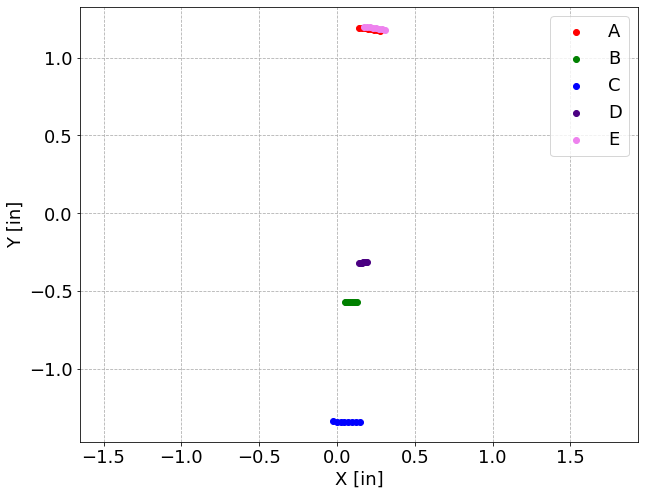

In [350]:
# X, Y plane should show this motion
fig, ax = plt.subplots()

colors = ['red', 'green', 'blue', 'indigo', 'violet']

for n, c in zip(names, colors):
    ax.scatter(x_dict[n], y_dict[n], c=c, label=n)

ax.axis('equal')
    
ax.set_xlabel('X [in]')
ax.set_ylabel('Y [in]')
ax.legend();

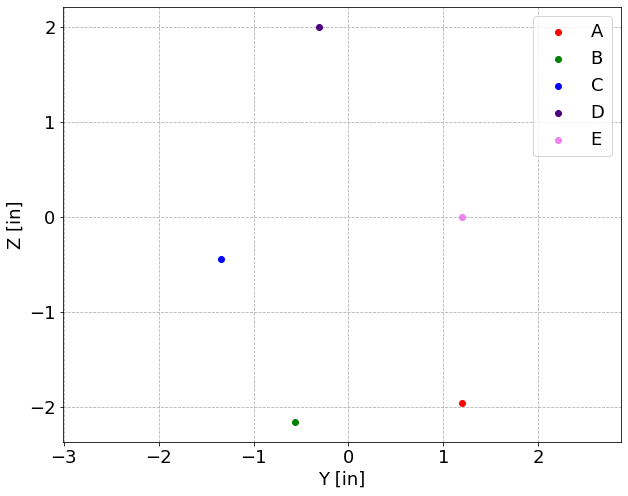

In [351]:
# Y, Z for one example
df_ = survey_dict['Repeatability - 16th Installation Backlash Test']

fig, ax = plt.subplots()

for n, c in zip(names, colors):
    df_p = df_.query(f'Point == "Kinematic-0.5_{n}"').copy()
    ax.scatter(df_p.Y, df_p.Z, c=c, label=n)

ax.axis('equal')
    
ax.set_xlabel('Y [in]')
ax.set_ylabel('Z [in]')
ax.legend();

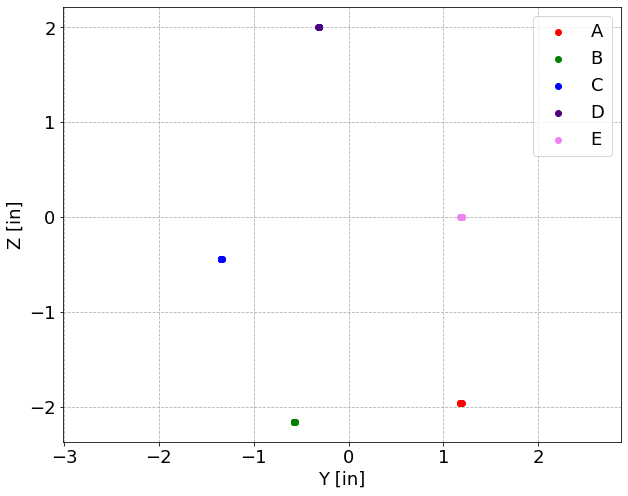

In [192]:
# X, Y plane should show this motion
fig, ax = plt.subplots()

colors = ['red', 'green', 'blue', 'indigo', 'violet']

for n, c in zip(names, colors):
    ax.scatter(y_dict[n], z_dict[n], c=c, label=n)

ax.axis('equal')
    
ax.set_xlabel('Y [in]')
ax.set_ylabel('Z [in]')
ax.legend();

In [281]:
# repeatability
names = ['A', 'B', 'C', 'D', 'E']
# degs = [-10, -9, -8, -7, -6, -5, -4, -3]

# x_vals = []
# y_vals = []
# z_vals = []

x_dict = {n: [] for n in names}
y_dict = {n: [] for n in names}
z_dict = {n: [] for n in names}

for k, df in survey_dict.items():
    if "Repeatability" in k:
        # remove outlier dataset
        if '12th' in k:
            continue
        for n in names:
            df_ = df.query(f'Point == "Kinematic-0.5_{n}"').copy()
            x_dict[n].append(df_.X)
            y_dict[n].append(df_.Y)
            z_dict[n].append(df_.Z)
for n in names:
    x_dict[n] = np.array(x_dict[n])
    y_dict[n] = np.array(y_dict[n])
    z_dict[n] = np.array(z_dict[n])
    x_dict[n] = x_dict[n] - np.mean(x_dict[n])
    y_dict[n] = y_dict[n] - np.mean(y_dict[n])
    z_dict[n] = z_dict[n] - np.mean(z_dict[n])

In [282]:
[k for k in survey_dict.keys() if 'Repeat' in k]

['Repeatability - 14th Installation',
 'Repeatability - 16th Installation',
 'Repeatability - 10th Installation Ideals',
 'Repeatability - 15th Installation',
 'Repeatability - 11th Installation',
 'Repeatability - 12th Installation',
 'Repeatability - 13th Installation',
 'Repeatability - 16th Installation Backlash Test']

In [283]:
print('dX [inch]')
for n in names:
    print(f"{n}: max={x_dict[n].max()}, min={x_dict[n].min()}")

dX [inch]
A: max=0.0018550000000000094, min=-0.0027429999999999954
B: max=0.0010577142857143007, min=-0.0011892857142856983
C: max=0.001953285714285685, min=-0.0020607142857143046
D: max=0.0017951428571428563, min=-0.002975857142857141
E: max=0.0024524285714285776, min=-0.0035015714285714095


In [284]:
print('dY [inch]')
for n in names:
    print(f"{n}: max={y_dict[n].max()}, min={y_dict[n].min()}")

dY [inch]
A: max=0.003998428571428514, min=-0.001683571428571673
B: max=0.0038441428571428515, min=-0.0015448571428571256
C: max=0.005037428571428526, min=-0.0018865714285716262
D: max=0.006689142857142838, min=-0.0024258571428571463
E: max=0.005302714285714494, min=-0.001975285714285624


In [285]:
print('dZ [inch]')
for n in names:
    print(f"{n}: max={z_dict[n].max()}, min={z_dict[n].min()}")

dZ [inch]
A: max=0.0003409999999999247, min=-0.0008890000000001397
B: max=0.0004134285714285646, min=-0.0002785714285713503
C: max=0.0009310000000000151, min=-0.00035999999999997145
D: max=0.00034700000000009723, min=-0.00020799999999976393
E: max=0.0002954285714285706, min=-0.0008425714285714291


In [286]:
(y_vals-y_vals[0]).max(), (y_vals-y_vals[0]).min()

(0.024227999999999916, -2.531402)

In [287]:
(z_vals-z_vals[0]).max(), (z_vals-z_vals[0]).min()

(3.9656830000000003, -0.20177)

In [288]:
(z_vals-z_vals[0]).argmax()

28

In [291]:
dMag.max()

0.007018602529662699

In [292]:
bins = np.arange(-0.008, 0.009, 0.001)

/tmp/ipykernel_3699246/3295600795.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels([f'{l:0.3f}' for l in axs[i, j].get_xticks()], rotation = 45)


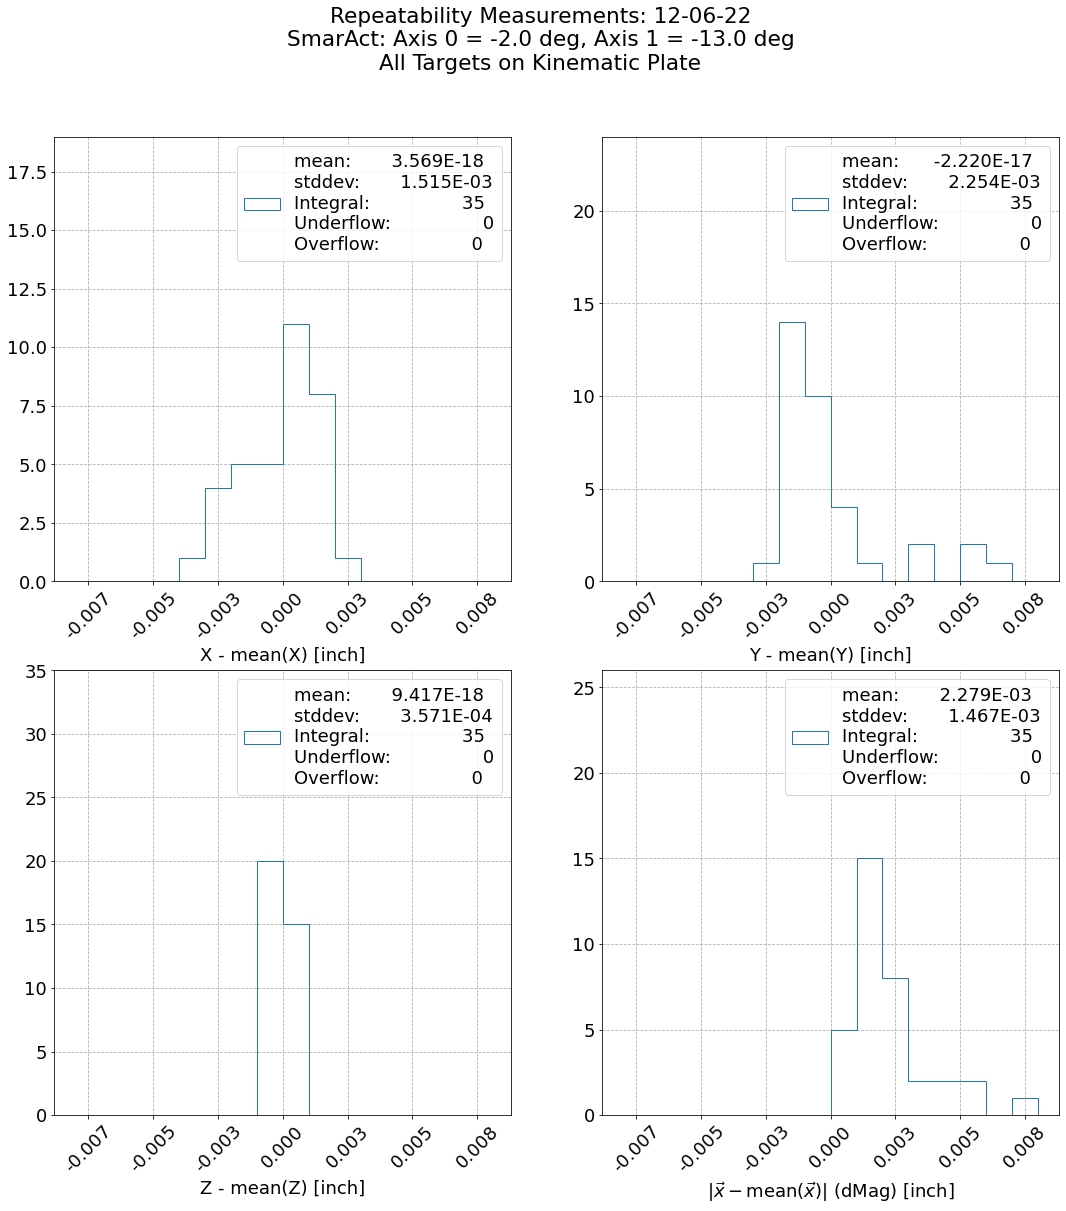

In [302]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))

dx = np.array(list(x_dict.values())).flatten()
dy = np.array(list(y_dict.values())).flatten()
dz = np.array(list(z_dict.values())).flatten()
# dMag = np.array(list(mag_dict.values())).flatten()
dMag = (dx**2 + dy**2 + dz**2)**(1/2)

n_dict = {0:dict(), 1:dict()}

n_dict[0][0], _, _ = axs[0, 0].hist(dx, bins=bins, histtype='step', label=get_label(dx, bins))
n_dict[0][1], _, _ = axs[0, 1].hist(dy, bins=bins, histtype='step', label=get_label(dy, bins))
n_dict[1][0], _, _ = axs[1, 0].hist(dz, bins=bins, histtype='step', label=get_label(dz, bins))
n_dict[1][1], _, _ = axs[1, 1].hist(dMag, bins=bins, histtype='step', label=get_label(dMag, bins))

for i in [0, 1]:
    for j in [0, 1]:
        axs[i, j].legend()
        axs[i, j].set_ylim([0, int(np.max(n_dict[i][j])*1.75)])
        axs[i, j].set_xticklabels([f'{l:0.3f}' for l in axs[i, j].get_xticks()], rotation = 45)
#         ax.get_xticks(), rotation = 45)
        
axs[0, 0].set_xlabel(r'X - mean(X) [inch]')
axs[0, 1].set_xlabel(r'Y - mean(Y) [inch]')
axs[1, 0].set_xlabel(r'Z - mean(Z) [inch]')
axs[1, 1].set_xlabel(r'$|\vec{x} - \mathrm{mean}(\vec{x})|$ (dMag) [inch]')
fig.suptitle(f'Repeatability Measurements: 12-06-22\nSmarAct: Axis 0 = -2.0 deg, Axis 1 = -13.0 deg\nAll Targets on Kinematic Plate');
fig.savefig(plot_dir+'12-06-22_point_by_point_deviations_hist.pdf')
fig.savefig(plot_dir+'12-06-22_point_by_point_deviations_hist.png');

In [311]:
bins_broad = np.arange(-0.008, 0.01, 0.002)

/tmp/ipykernel_3699246/160210830.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels([f'{l:0.3f}' for l in axs[i, j].get_xticks()], rotation = 45)


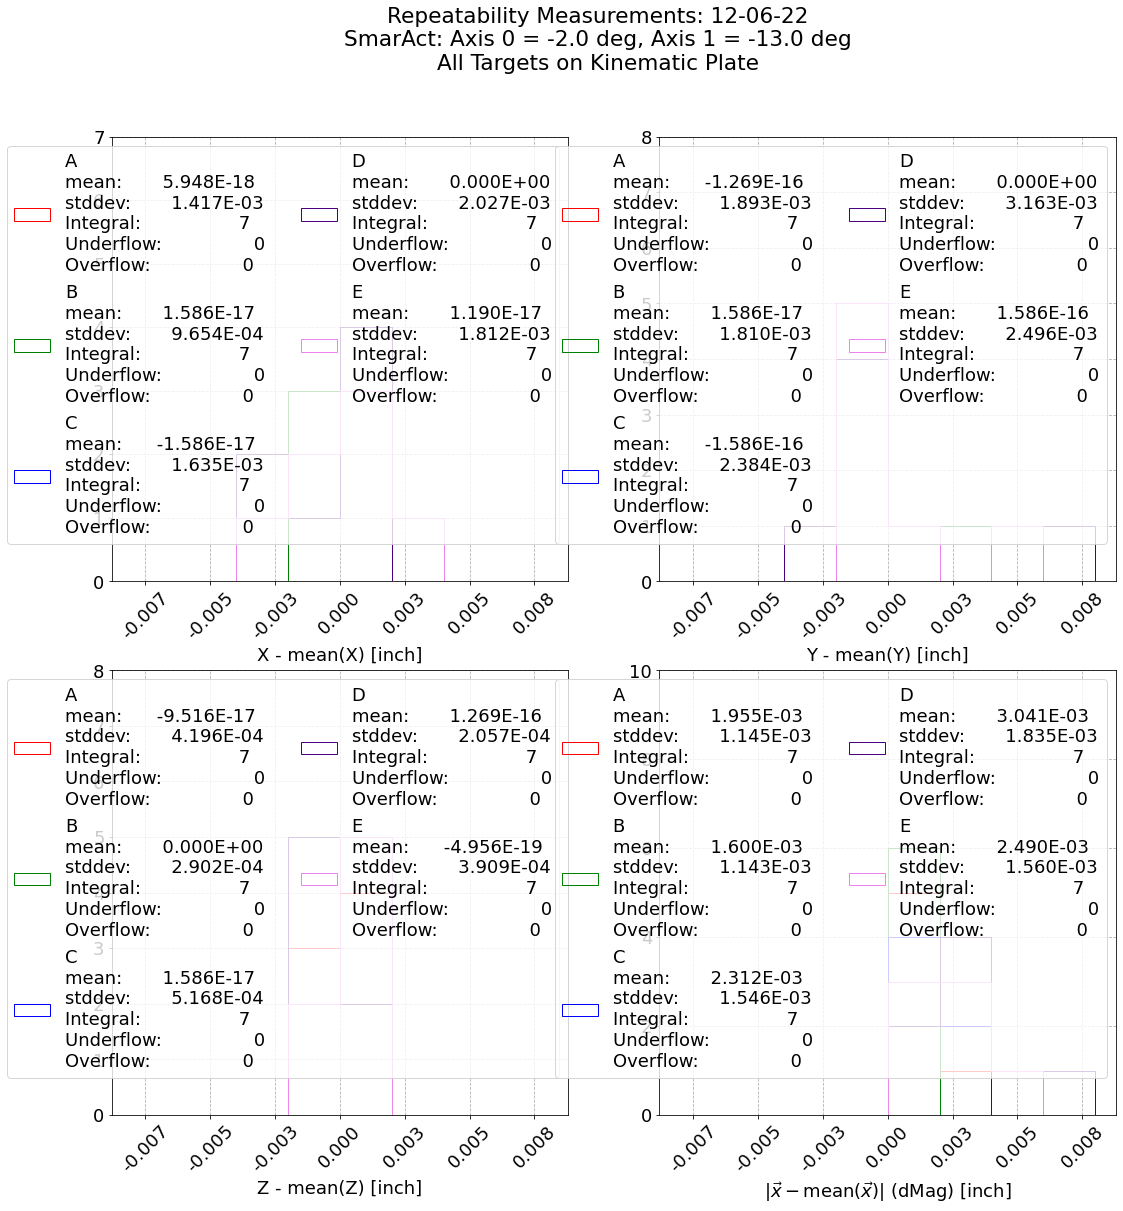

In [313]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))


n_dict = {0:{0:[], 1:[]}, 1:{0:[], 1:[]}}

for n, c in zip(names, colors):
    dx = np.array(x_dict[n]).flatten()
    dy = np.array(y_dict[n]).flatten()
    dz = np.array(z_dict[n]).flatten()
    # dMag = np.array(list(mag_dict.values())).flatten()
    dMag = (dx**2 + dy**2 + dz**2)**(1/2)



    n_, _, _ = axs[0, 0].hist(dx, bins=bins_broad, histtype='step', stacked=True, color=c, label=f'{n}\n'+get_label(dx, bins))
    n_dict[0][0].append(n_)
    n_, _, _ = axs[0, 1].hist(dy, bins=bins_broad, histtype='step', stacked=True, color=c, label=f'{n}\n'+get_label(dy, bins))
    n_dict[0][1].append(n_)
    n_, _, _ = axs[1, 0].hist(dz, bins=bins_broad, histtype='step', stacked=True, color=c, label=f'{n}\n'+get_label(dz, bins))
    n_dict[1][0].append(n_)
    n_, _, _ = axs[1, 1].hist(dMag, bins=bins_broad, histtype='step', stacked=True, color=c, label=f'{n}\n'+get_label(dMag, bins))
    n_dict[1][1].append(n_)

for i in [0, 1]:
    for j in [0, 1]:
        axs[i, j].legend(ncol=2)
        axs[i, j].set_ylim([0, int(np.max(n_dict[i][j])*1.75)])
        axs[i, j].set_xticklabels([f'{l:0.3f}' for l in axs[i, j].get_xticks()], rotation = 45)
#         ax.get_xticks(), rotation = 45)
        
axs[0, 0].set_xlabel(r'X - mean(X) [inch]')
axs[0, 1].set_xlabel(r'Y - mean(Y) [inch]')
axs[1, 0].set_xlabel(r'Z - mean(Z) [inch]')
axs[1, 1].set_xlabel(r'$|\vec{x} - \mathrm{mean}(\vec{x})|$ (dMag) [inch]')
fig.suptitle(f'Repeatability Measurements: 12-06-22\nSmarAct: Axis 0 = -2.0 deg, Axis 1 = -13.0 deg\nAll Targets on Kinematic Plate');
fig.savefig(plot_dir+'12-06-22_point_by_point_deviations_hist_split.pdf')
fig.savefig(plot_dir+'12-06-22_point_by_point_deviations_hist_split.png');

In [222]:
np.array(list(z_dict.values())).flatten()

array([ 4.606250e-04,  6.496250e-04,  4.216250e-04, -5.803750e-04,
        2.746250e-04, -2.160375e-03,  2.906250e-04,  6.436250e-04,
       -2.776250e-04, -2.996250e-04,  2.123750e-04,  1.983750e-04,
       -4.736250e-04,  1.407375e-03, -4.796250e-04, -2.876250e-04,
       -6.212500e-04, -7.212500e-04,  1.047500e-04,  5.007500e-04,
       -7.902500e-04,  3.011750e-03, -7.872500e-04, -6.972500e-04,
       -1.902500e-04, -2.142500e-04,  2.077500e-04,  8.875000e-05,
       -3.472500e-04,  9.747500e-04, -2.822500e-04, -2.372500e-04,
        4.256250e-04,  5.946250e-04,  4.066250e-04, -5.383750e-04,
        2.516250e-04, -2.129375e-03,  3.896250e-04,  5.996250e-04])

# 1. Pole Mapping

## a. Mapping / Fitting

## b. Field Vector

# 2. SmarAct Along $\vec{B}$

# 3. SmarAct Repeatability

In [352]:
# load data
data_file = raw_ddir+'2022-12-06 093302slow.txt'

In [353]:
cols = ['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]', 'NMR [FFT]',
        'SmarAct_Meas_Angle_1', 'SmarAct_Meas_Rotation_Angle_1', 'SmarAct_Meas_Angle_2', 'SmarAct_Meas_Rotation_Angle_2']

In [354]:
df = load_data(data_file, header=cols).iloc[1:]

In [355]:
# skip to when we started  measuring
t0 = '12-06-2022 10:29:07'
df = df.query(f'"{t0}" <= Datetime')

In [356]:
df

,Time,Magnet Current [A],Magnet Voltage [V],NMR [T],NMR [FFT],SmarAct_Meas_Angle_1,SmarAct_Meas_Rotation_Angle_1,SmarAct_Meas_Angle_2,SmarAct_Meas_Rotation_Angle_2,seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,
2022-12-06 10:29:08,12/6/2022 10:29:08 AM,0.0,0.0,0.0,0.0,357.999002,-1.0,346.997576,-1.0,3363.0,0.934167,0.038924
2022-12-06 10:30:35,12/6/2022 10:30:35 AM,0.0,0.0,0.0,0.0,358.007672,-1.0,346.997554,-1.0,3450.0,0.958333,0.039931
2022-12-06 10:30:36,12/6/2022 10:30:36 AM,0.0,0.0,0.0,0.0,358.007672,-1.0,346.997558,-1.0,3451.0,0.958611,0.039942
2022-12-06 10:31:36,12/6/2022 10:31:36 AM,0.0,0.0,0.0,0.0,358.007655,-1.0,346.997548,-1.0,3511.0,0.975278,0.040637
2022-12-06 10:32:36,12/6/2022 10:32:36 AM,0.0,0.0,0.0,0.0,358.007677,-1.0,346.997547,-1.0,3571.0,0.991944,0.041331
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 11:23:55,12/8/2022 11:23:55 AM,0.0,0.0,0.0,0.0,357.999999,-1.0,347.000001,-1.0,179450.0,49.847222,2.076968
2022-12-08 11:24:55,12/8/2022 11:24:55 AM,0.0,0.0,0.0,0.0,358.000000,-1.0,346.999998,-1.0,179510.0,49.863889,2.077662
2022-12-08 11:25:55,12/8/2022 11:25:55 AM,0.0,0.0,0.0,0.0,357.999991,-1.0,346.999998,-1.0,179570.0,49.880556,2.078356


## a. Home position

In [137]:
# width of wide end of Hall probe card, in inches
# divided by 2 to get approx distance to the kinematic reflectors from center / rotation axis
#lever = mm_to_inch(56.495) / 2 # witdh of Hall card
level = mm_to_inch(61.32) / 2 # A-B reflectors on kinematic card
lever

1.1121062992125985

In [138]:
lever

1.1121062992125985

In [139]:
lever * np.sin(np.radians(0.001))

1.9409916552443635e-05

In [140]:
lever * np.sin(np.radians(0.0025))

4.852479136817527e-05

In [148]:
# THIS IS THE SMALLEST CHANGE THE LASER COULD RELIABLY PICKUP
# deg, rad
np.degrees(np.arcsin(0.003 / lever)), np.arcsin(0.003 / lever)

(0.15456035734276508, 0.002697587128690244)

In [413]:
# API Radian R20 docs suggest 15 micrometer = 0.0006 inch
np.degrees(np.arcsin(0.0006 / lever)), np.arcsin(0.0006 / lever)

(0.030912035477135478, 0.0005395167975693104)

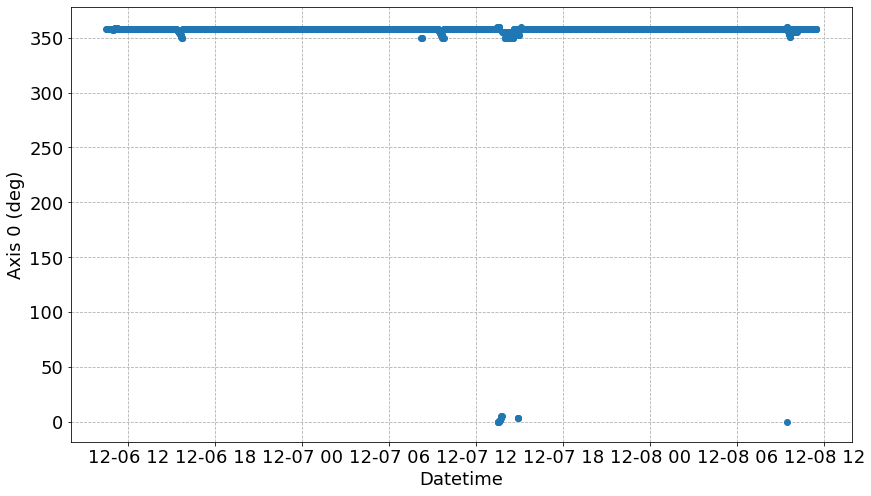

In [357]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.scatter(df.index, df.SmarAct_Meas_Angle_1)

ax.set_xlabel("Datetime")
ax.set_ylabel("Axis 0 (deg)");

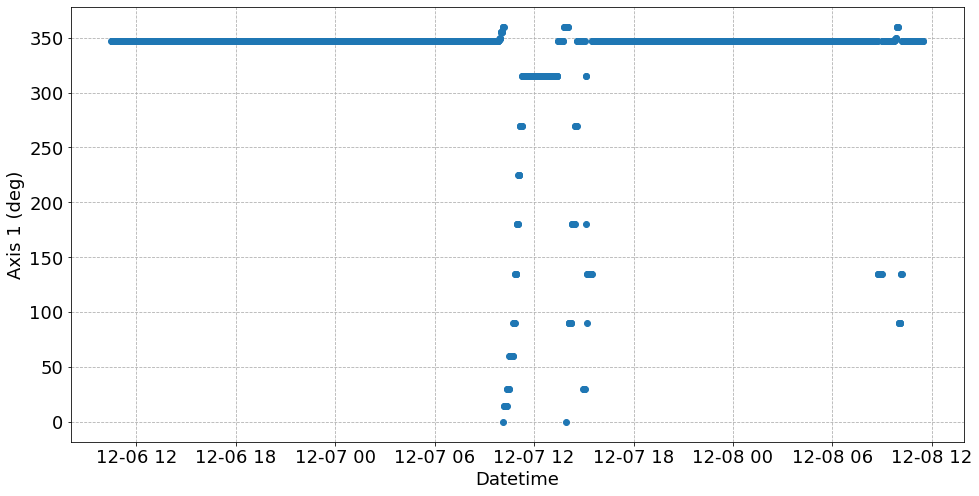

In [359]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(df.index, df.SmarAct_Meas_Angle_2)

ax.set_xlabel("Datetime")
ax.set_ylabel("Axis 1 (deg)");

In [360]:
#df_ = df.query('"12-06-22 11:13:00" <= Datetime <= "12-06-22 12:03:00"') # before fix
df_ = df.query('"12-06-22 12:03:00" <= Datetime') # before fix
df_[['SmarAct_Meas_Angle_1', 'SmarAct_Meas_Angle_2']].describe()

,SmarAct_Meas_Angle_1,SmarAct_Meas_Angle_2
count,2807.000000,2807.000000
mean,355.799752,334.370855
std,26.775991,51.900890
min,0.000000,0.000000
25%,357.999994,346.999994
50%,357.999996,346.999997
75%,357.999999,346.999998
max,359.999998,359.999999


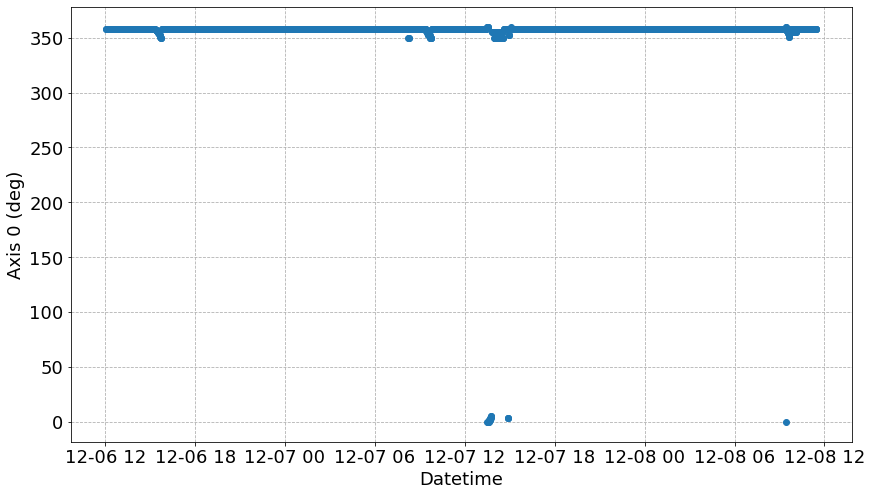

In [361]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.scatter(df_.index, df_.SmarAct_Meas_Angle_1)

ax.set_xlabel("Datetime")
ax.set_ylabel("Axis 0 (deg)");

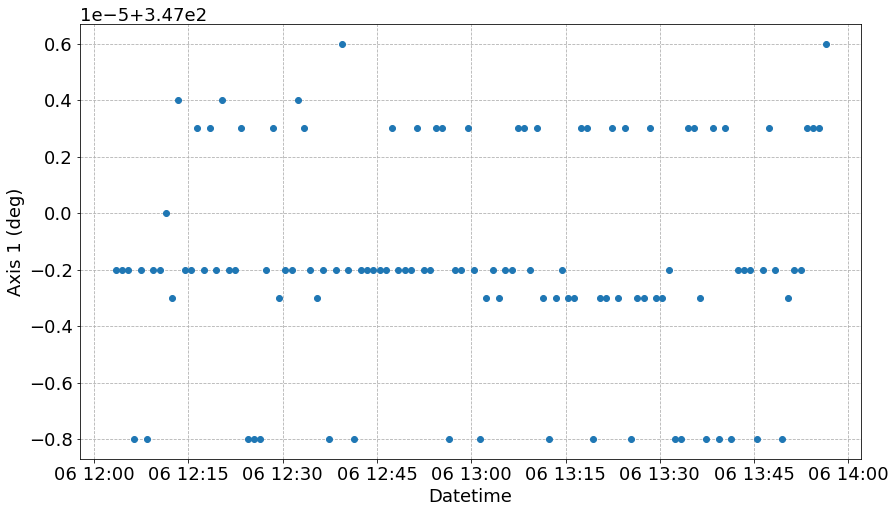

In [146]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.scatter(df_.index, df_.SmarAct_Meas_Angle_2)

ax.set_xlabel("Datetime")
ax.set_ylabel("Axis 1 (deg)");

In [362]:
df_ = df.query('"12-06-22 12:03:00" <= Datetime') # after fix (locking)
df_[['SmarAct_Meas_Angle_1', 'SmarAct_Meas_Angle_2']].describe()

,SmarAct_Meas_Angle_1,SmarAct_Meas_Angle_2
count,2807.000000,2807.000000
mean,355.799752,334.370855
std,26.775991,51.900890
min,0.000000,0.000000
25%,357.999994,346.999994
50%,357.999996,346.999997
75%,357.999999,346.999998
max,359.999998,359.999999


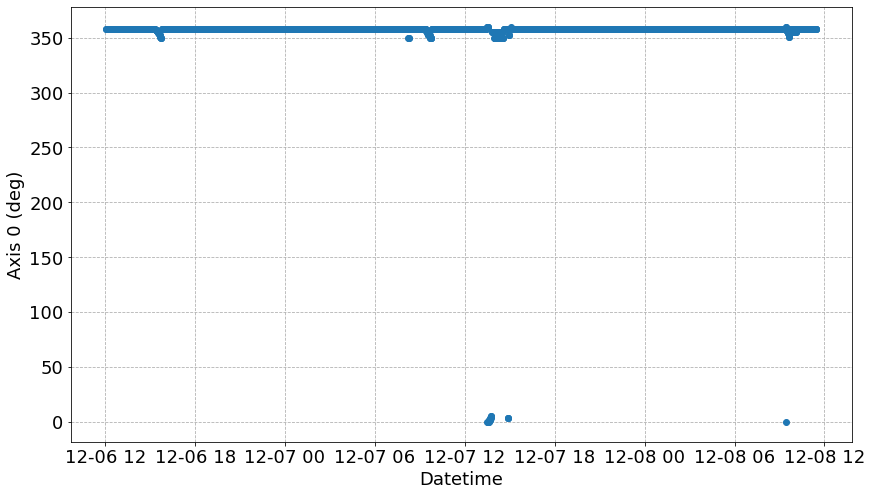

In [363]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.scatter(df_.index, df_.SmarAct_Meas_Angle_1)

ax.set_xlabel("Datetime")
ax.set_ylabel("Axis 0 (deg)");

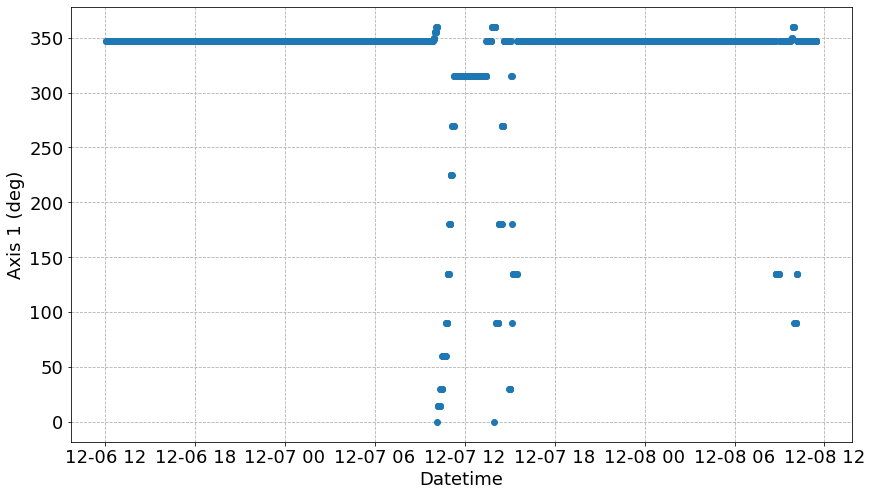

In [364]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.scatter(df_.index, df_.SmarAct_Meas_Angle_2)

ax.set_xlabel("Datetime")
ax.set_ylabel("Axis 1 (deg)");

## b. Moving to different locations (includes home)

# 4. SmarAct Encoder Reading vs. Physical Rotation

# 5. SmarAct Mapping to Field Vector Angle